In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast.models import TimesNet
from neuralforecast.core import NeuralForecast

/home/maybe/miniconda3/envs/task2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-16 12:30:32,204	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-07-16 12:30:32,283	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# 1. Чтение и обработка данных
file_path = 'evs1_012_1_bar_harmonics_median_new.csv'
df = pd.read_csv(file_path, parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)

# 2. Расчёт разности значений (дельты)
df['delta_value'] = df['value'].diff()
df = df.dropna(subset=['delta_value']).reset_index(drop=True)

# 3. Подготовка данных для модели
df_delta = df.rename(columns={'date': 'ds', 'delta_value': 'y'})
df_delta['unique_id'] = 'series_1'
df_delta = df_delta[['unique_id', 'ds', 'y']]

In [3]:
# 4. Задаём параметры модели
input_size = 14
horizon = 100
freq = 'D'

In [4]:
# 5. Обучение и прогнозирование модели на ряде приращений
model = TimesNet(
    h=horizon,
    input_size=input_size,
    max_steps=100,
    learning_rate=1e-3,
    scaler_type='standard'
)
nf = NeuralForecast(models=[model], freq=freq)
nf.fit(df=df_delta)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear   

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s, v_num=197, train_loss_step=0.954, train_loss_epoch=0.954]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s, v_num=197, train_loss_step=0.954, train_loss_epoch=0.954]


In [5]:
forecast_df = nf.predict()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.46it/s]


In [6]:
# 6. Восстановление абсолютных значений прогноза
# a) Последнее известное значение исходного ряда
last_value = df['value'].iloc[-1]

# b) Кумулятивная сумма прогнозных приращений + последнее значение
forecast_df['restored_value'] = last_value + forecast_df['TimesNet'].cumsum()

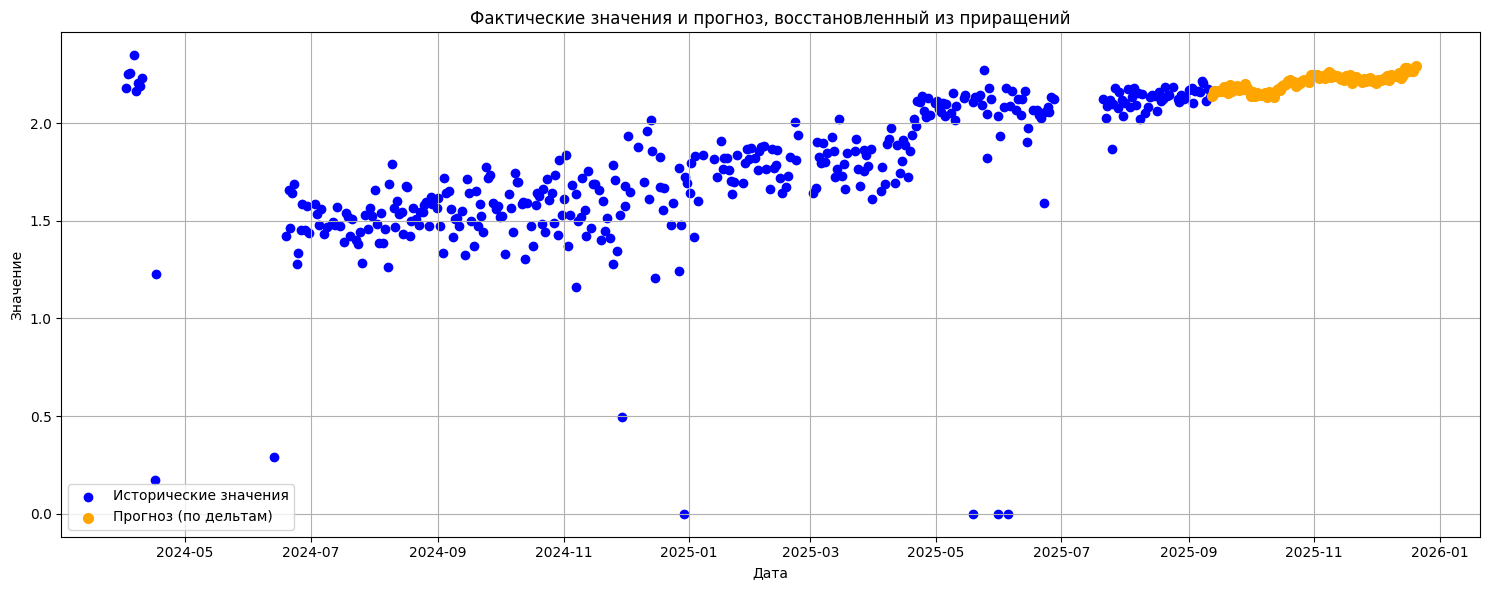

In [7]:
# 7. Итоговый график: реальные значения и восстановленные прогнозы
plt.figure(figsize=(15, 6))
plt.scatter(df['date'], df['value'], label='Исторические значения', color='blue')
plt.scatter(forecast_df['ds'], forecast_df['restored_value'], label='Прогноз (по дельтам)', color='orange', linewidth=2)
plt.title('Фактические значения и прогноз, восстановленный из приращений')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()